In [1]:
import numpy as np
import matplotlib.pyplot as plt

from satforecast.data import data

data.download()
image_dir = data.process_gs_rainfall_daily()
image_files = data.get_files(image_dir, '*.npy')

In [2]:
import torch
from torch import nn


class ConvRNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, kernal_size_, padding_, out_size=1):
        super().__init__()
        self.hidden_channels = hidden_channels
        self.conv1 = nn.Conv2d(in_channels + hidden_channels, hidden_channels, kernel_size=kernal_size_, padding=padding_)
        self.conv2 = nn.Conv2d(hidden_channels, hidden_channels, kernel_size=kernal_size_, padding=padding_)
        self.conv3 = nn.Conv2d(hidden_channels, in_channels, kernel_size=kernal_size_, padding=padding_)

    def forward(self, in_tensor, h):
        h = torch.cat((in_tensor, h), dim=1)
        h = torch.tanh(self.conv1(h))
        h = torch.tanh(self.conv2(h))
        return self.conv3(h), h

    def init_hidden(self, batch_size, image_size):
        return torch.zeros(batch_size, self.hidden_channels, *image_size)

In [3]:
def predict(model, X, seq_len):
    """ For a single batch """

    hidden = model.init_hidden(X.shape[0], X.shape[-2:])

    for step in range(seq_len - 1):
        _, hidden = model(X[:,step], hidden)

    pred, _ = model(X[:, -1], hidden)
    return pred

Time to make validation tensors: 0.07057309150695801
Size of X_val = 0.101GB , Size of y_val = 0.020GB 
Batch 0: Validation loss = 0.1902666836977005, Train time = 2.3, Update time = 6.0, Validation time = 2.9
Batch 1: Validation loss = 0.179221048951149, Train time = 3.0, Update time = 6.4, Validation time = 2.3
Batch 2: Validation loss = 0.17015330493450165, Train time = 2.2, Update time = 5.8, Validation time = 2.2
Batch 3: Validation loss = 0.16271623969078064, Train time = 2.2, Update time = 5.4, Validation time = 2.5
Batch 4: Validation loss = 0.15654787421226501, Train time = 2.2, Update time = 5.2, Validation time = 2.5
Batch 5: Validation loss = 0.15142369270324707, Train time = 2.6, Update time = 6.6, Validation time = 2.6
CPU times: user 1min 7s, sys: 57 s, total: 2min 4s
Wall time: 1min 5s


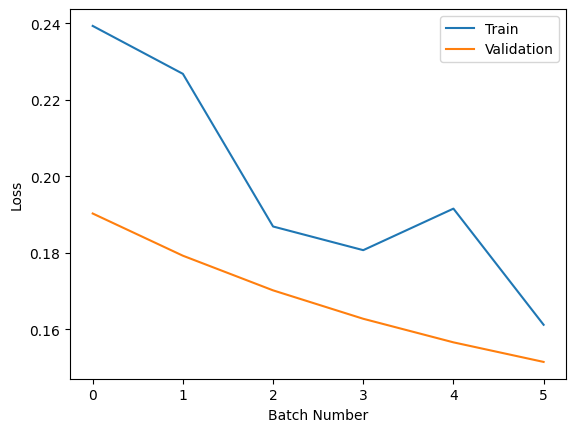

In [4]:
from time import time
from math import ceil

from satforecast.modeling.model_selection import rolling_batch

def tsize(t):
    return t.element_size() * t.nelement() / (1024)**3

def print_sizes(**args):
    print(', '.join([f'Size of {k} = {tsize(v):.3f}GB ' for k, v in args.items()]))

def train(model, files_list, train_frac, val_frac, seq_len, batch_size, min_improv=0, max_iter_improv=100):

    n_images = len(files_list)
    train_n = int(train_frac * n_images)
    images_per_batch = seq_len + batch_size
    n_batches = train_n / images_per_batch

    model.train()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())
    train_losses = []
    
    if val_frac != 0:
        time_start = time()
        X_val, y_val = rolling_batch(
                                        files = files_list,
                                        start = train_n,
                                        stop = int((train_frac + val_frac)*n_images),
                                        seq_len = seq_len
                                        )
        print(f'Time to make validation tensors: {time() - time_start}')
        print_sizes(X_val=X_val, y_val=y_val)
        val_losses = []

    for batch_n in range(int(n_batches)):
        
        # Use smaller final batch if needed
        # Use range(ceil(n_batches)) when correcting this
        # if batch_n == ceil(n_batches):
        #    batch_size = train_n - int(n_batches) * images_per_batch - seq_len
        #    print(batch_size) # needs to be passes (and used) in rolling_batch
        
        # Make training batch
        start_batch_ind = batch_n * images_per_batch
        stop_batch_ind = (batch_n + 1) * images_per_batch
        X_train, y_train = rolling_batch(
                                            files = files_list,
                                            start = start_batch_ind,
                                            stop = stop_batch_ind,
                                            seq_len = seq_len
                                            )

        # Predictions and loss on training batch
        train_start = time()
        y_pred = predict(model, X_train, seq_len)
        train_loss = criterion(y_pred, y_train)
        train_losses.append(train_loss.item())
        train_time = round(time() - train_start, 1)
        del X_train, y_train, y_pred

        # Update model
        model_start = time()
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        model_time = round(time() - model_start, 1)
        if val_frac == 0:
            print(
                f'Batch {batch_n}:',
                f'Train loss = {train_losses[-1]},',
                f'Train time = {train_time},',
                f'Update time = {model_time}'
                )
        

        # Validation if not refitting
        if val_frac != 0:
            val_start = time()
            model.eval()
            y_pred = predict(model, X_val, seq_len)
            val_loss = criterion(y_pred, y_val)
            val_losses.append(val_loss.item())
            val_time = round(time() - val_start, 1)
            del y_pred, val_loss
            print(
                f'Batch {batch_n}:',
                f'Validation loss = {val_losses[-1]},',
                f'Train time = {train_time},',
                f'Update time = {model_time},',
                f'Validation time = {val_time}'
                )
            
            # Early stopping
            if batch_n > max_iter_improv \
                and val_losses[-(max_iter_improv + 1)] - min_improv <= min(val_losses[-max_iter_improv:]):
                print(f'\n!!! Early stopping triggered after {batch_n + 1} batches !!!\n')
                break
            
            model.train()

    if val_frac == 0:
        return train_losses
    else:
        return train_losses, val_losses

# Test train function
TEST_N_IMAGES = 100
test_image_files = image_files[:TEST_N_IMAGES]
test_crnn = ConvRNN(in_channels=1, hidden_channels=2, kernal_size_=3, padding_=1)
%time train_loss, val_loss = train(test_crnn, test_image_files, 0.6, 0.1, 5, 5, min_improv=0.003, max_iter_improv=1)
plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Validation')
plt.legend()
plt.xlabel('Batch Number')
plt.ylabel('Loss');

## Semi-full training

Time to make validation tensors: 0.15163397789001465
Size of X_val = 0.402GB , Size of y_val = 0.080GB 
Batch 0: Validation loss = 0.15394330024719238, Train time = 2.3, Update time = 5.1, Validation time = 8.7
Batch 1: Validation loss = 0.14872333407402039, Train time = 2.3, Update time = 4.9, Validation time = 8.7
Batch 2: Validation loss = 0.1436200737953186, Train time = 2.6, Update time = 5.8, Validation time = 9.2
Batch 3: Validation loss = 0.13863712549209595, Train time = 2.3, Update time = 5.0, Validation time = 8.6
Batch 4: Validation loss = 0.13376326858997345, Train time = 2.2, Update time = 5.1, Validation time = 8.7
Batch 5: Validation loss = 0.12904545664787292, Train time = 2.3, Update time = 5.0, Validation time = 8.7
Batch 6: Validation loss = 0.12449689954519272, Train time = 2.5, Update time = 5.2, Validation time = 8.7
Batch 7: Validation loss = 0.12013327330350876, Train time = 2.3, Update time = 5.5, Validation time = 10.1
Batch 8: Validation loss = 0.11595101654

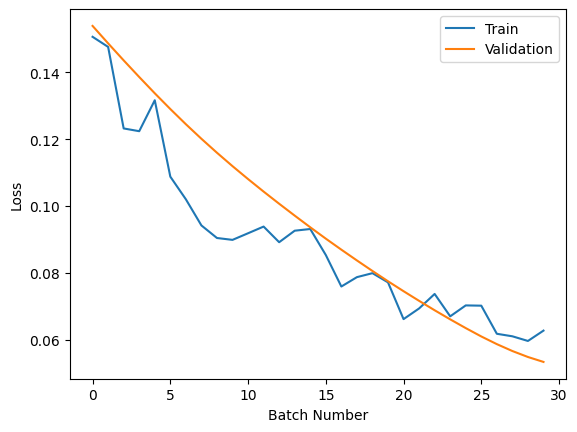

In [5]:
DEV_N_IMAGES = 500
TRAIN_FRAC = 0.6
VAL_FRAC = 0.05
SEQ_LEN = 5
BATCH_SIZE = 5

dev_image_files = image_files[:DEV_N_IMAGES]

dev_crnn = ConvRNN(in_channels=1, hidden_channels=2, kernal_size_=3, padding_=1)
%time train_loss, val_loss = train(dev_crnn, dev_image_files, 0.6, 0.05, 5, 5, min_improv=0.001, max_iter_improv=2)
plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Validation')
plt.legend()
plt.xlabel('Batch Number')
plt.ylabel('Loss');

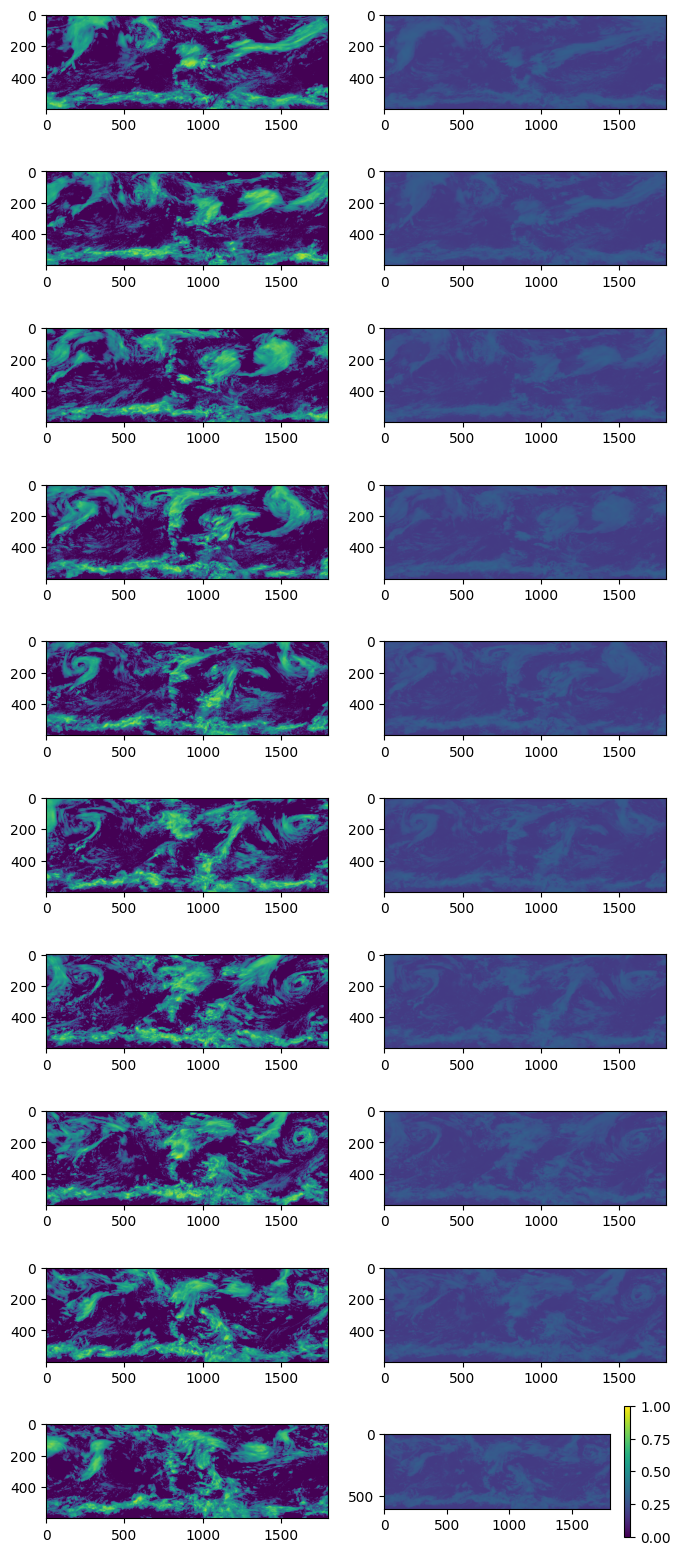

In [7]:
N_DAYS = 10
COLS = 2
IMAGE_SIZE = (600, 1800)

fig, axs = plt.subplots(N_DAYS, COLS, figsize=(8, 2*N_DAYS))

dev_crnn.eval()

for i in range(N_DAYS):

    # Get predicted
    X, y = rolling_batch(image_files[DEV_N_IMAGES + i: DEV_N_IMAGES + i + 5 + 1], start=0, stop=5 + 1, seq_len=5)
    y = torch.reshape(y, IMAGE_SIZE).numpy()
    y_pred = torch.reshape(predict(dev_crnn, X, 5), IMAGE_SIZE).detach().numpy()

    # Plot real
    plt.subplot(N_DAYS, COLS, i * COLS + 1)
    plt.imshow(y.astype('float32'), vmin=0, vmax=1)

    # Plot predicted
    plt.subplot(N_DAYS, COLS, i * COLS + 2)
    plt.imshow(y_pred.astype('float32'), vmin=0, vmax=1)

plt.colorbar();